# Hedging Outside of Utopia: Five Easy Pieces

Simon Ellersgaard Nielsen, 2023

Financial mathematics is often done under highly idealised assumptions, especially at the introductory level. This is unfortunate since students can leave academic programs with a somewhat disconnected understanding of the practical nature of financial engineering. In this notebook we endeavour to walk a fine line between academia and industry, exploring one of the most fundamental aspects of derivatives trading - *hedging* - in five easy pieces. Specifically, we will strive for a kind of quasi- (or pseudo-) realism, where simulated data is considered, but a subset of the original [Black-Scholes-Merton assumptions](https://www.macroption.com/black-scholes-assumptions/) gradually are alleviated.   

1. In [Delta Hedging at Discrete Intervals](#essay1) we explore the effects of hedging at discrete intervals: what error do we accrue vis-a-vis hedging in a continuous time economy?
2. In [Gamma Hedging at Discrete Intervals](#essay2) we extend the previous essay by hedging the second order sensitivity to the underlying with another derivative. What impact does this have on the hedge error?
3. In [Hedging with Volatility Uncertainty](#essay3) we dismiss the idea that implied, realised, and hedging volatilities are all equal. What happens to the PnL of our hedge portfolio when these are allowed to be different?
4. In [Hedging with Transaction Costs](#essay4) we banish the frictionless economy while seeking a notion of 'optimal hedging'.
5. Finally, in [Risk Minimising Hedges](#essay5) we consider how necessarily imperfect hedges nonetheless can be made as good as possible, focusing on the case of stochastic volatility.

No originality is claimed here: these are known results, which (regrettably) remain obscure to many who *ought to know*. The code and presentation is my own work. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from typing import Union
import statsmodels.api as sm
from matplotlib.ticker import FormatStrFormatter
from tqdm import tqdm
from scipy.integrate import quad
import warnings

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Prefix: Simulating Geometric Brownian Motion

For many of the following exercises, we will need access to simulated price data. For our purposes we will assume share prices are governed by geometric Brownian motion (GBM), i.e. the price process $\{S_t\}_{t \geq 0}$ is governed by the SDE

$$
dS_t = \mu S_t dt + \sigma S_t dW_t,
$$

where $\mu$ is the drift, $\sigma$ is the (real) volatility, and $\{W_t\}_{t \geq 0}$ is a Wiener process. Derivatives written thereon will be taken to be plain vanilla call options $C=C(K, \tau)$ with strike $K$ and time to maturity $\tau$. 

Our parameters of choice will be:  

In [2]:
S_0 = 100  # spot
K = 110  # strike
τ = 1  # time to maturity
μ = 0.1  # mean drift
σ = 0.2  # volatility
r = 0.01  # risk free rate
o = "c"  # option type

We will simulate $M$ such paths at discrete step sizes $\delta t$. To this end we will make use of the fact that the GBM SDE has solution

$$
S_{t+\delta t} = S_t e^{\left(\mu - \tfrac{1}{2}\sigma^2 \right) \delta t + \sigma \sqrt{\delta t} Z},
$$
where $Z \sim N(0,1)$ is a standard normal random variable. This method is exact in the sense that it does not introduce any discretisation error: the $(S_{\delta t}, S_{2 \delta t}, ...)$ it produces has the joint distribution of the geometric Brownian motion. 

In [3]:
def path_simulator(M: int = 500, dt: float = 1 / 252) -> pd.DataFrame:
    x = np.arange(0, τ + dt, dt)
    xb = x.reshape((len(x), 1))
    S = pd.DataFrame(None, index=x, columns=np.arange(0, M))
    for ti, t in enumerate(xb):
        if ti == 0:
            S.iloc[0] = S_0
        else:
            Z = np.random.normal(0, 1, M)
            S.iloc[ti] = S.iloc[ti - 1] * np.exp(
                (μ - 0.5 * σ**2) * dt + σ * np.sqrt(dt) * Z
            )
    S = S.astype(float)
    return S


S = path_simulator()

A subset of the simulated paths are shown below:

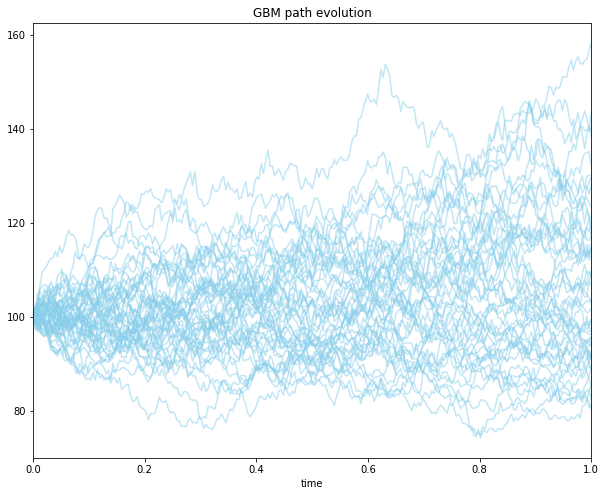

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(S[S.columns[::10]], alpha=0.5, c="skyblue")
ax.set_xlabel("time")
ax.margins(x=0)
ax.set_title("GBM path evolution");

As a sanity check, it is helpful to estimate the parameters $\mu$ and $\sigma$ from the generated paths. The distribution of $\hat{\mu}$ and $\hat{\sigma}$ are exhibited below. Note that while the *mean* estimators coincide very well with the governing parameters, there is significant variability in $\hat{\mu}$. This reiterates one of my favourite points about empirical finance: **your estimate of the mean return is probably garbage**.  

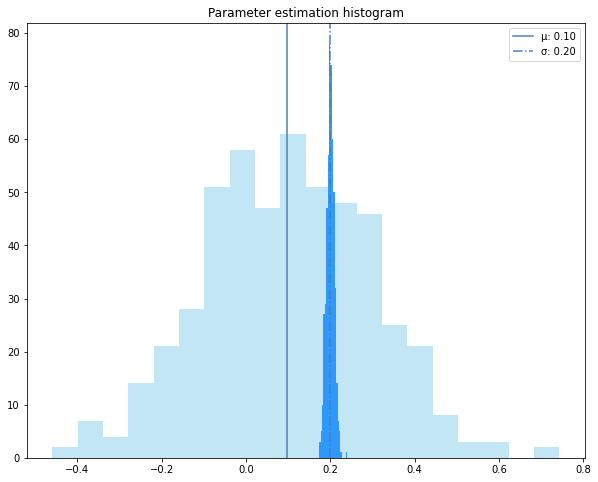

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dt = S.index[1]
sd = np.log((S / S.shift(1)).iloc[1:]).std() / np.sqrt(dt)
mn = (np.log((S / S.shift(1)).iloc[1:]).mean() / dt) + 0.5 * sd**2
ax.hist(mn, bins=20, alpha=0.5, color='skyblue')
ax.hist(sd, bins=20, alpha=0.9, color='dodgerblue')
ax.axvline(mn.mean(), c="steelblue", label="μ: {:.2f}".format(mn.mean()))
ax.axvline(sd.mean(), c="steelblue", linestyle='-.', label="σ: {:.2f}".format(sd.mean()))
ax.legend()
ax.set_title("Parameter estimation histogram");

# Black-Scholes-Merton Pricing

Throughout this notebook we will repeatedly make use of the Black-Scholes formula and the associated Greeks. The class below implements these formulae in a vectorised manner, meaning that for a fixed option type (put or call), it can handle multiple configurations of (price, strike, maturity, volatility, risk free rate, dividend yield) at a time without any for loops. This is accomplished through numpy arrays. Note that the broadcasting functionality permits mixing vectors and scalars in the function input. 

In [6]:
class BSM:
    def __init__(
        self,
        S: Union[float, np.array],
        K: Union[float, np.array],
        τ: Union[float, np.array],
        σ: Union[float, np.array],
        r: Union[float, np.array],
        q: Union[float, np.array],
        o: str,
    ):
        """
        A Black-Scholes option pricer with greeks.
        S: The spot price
        K: The strike price
        τ: The time to maturity
        σ: The implied volatility
        r: The risk free rate
        q: The continuous dividend yield
        o: The option type, call (c), put (p)

        Simon Ellersgaard Nielsen
        """

        self.S = np.asarray(S)
        self.K = np.asarray(K)
        self.τ = np.maximum(np.asarray(τ), 1e-20)
        self.σ = np.asarray(σ)
        self.r = np.asarray(r)
        self.q = np.asarray(q)
        self.o = self.otype(o)

        assert (self.S >= 0).all()
        assert (self.K >= 0).all()
        assert (self.τ > 0).all()
        assert (self.σ >= 0).all()
        assert (self.r >= 0).all()
        assert (self.q >= 0).all()

        self.components()

    def components(self):
        self.d1 = (
            np.log(self.S / self.K) + (self.r - self.q + 0.5 * self.σ**2) * self.τ
        ) / (self.σ * np.sqrt(self.τ))
        self.d2 = self.d1 - self.σ * np.sqrt(self.τ)
        self.Φ1 = norm.cdf(self.d1)
        self.Φ2 = norm.cdf(self.d2)
        self.ϕ1 = norm.pdf(self.d1)
        self.ϕ2 = norm.pdf(self.d2)
        self.Dr = np.exp(-self.r * self.τ)
        self.Dq = np.exp(-self.q * self.τ)

    @staticmethod
    def otype(o):
        assert type(o) == str
        assert o in ["c", "C", "call", "Call", "p", "P", "put", "Put"]
        if o in ["c", "C", "call", "Call"]:
            return "c"
        else:
            return "p"

    def price(self):
        if self.o == "c":
            return self.S * self.Dq * self.Φ1 - self.Dr * self.K * self.Φ2
        else:
            return self.Dr * self.K * (1 - self.Φ2) - self.S * self.Dq * (1 - self.Φ1)

    def delta(self):
        if self.o == "c":
            return self.Dq * self.Φ1
        else:
            return -self.Dq * (1 - self.Φ1)

    def vega(self):
        return self.S * self.Dq * self.ϕ1 * np.sqrt(self.τ)

    def theta(self):
        if self.o == "c":
            return (
                -self.Dq * self.S * self.ϕ1 * self.σ / (2 * np.sqrt(self.τ))
                - self.r * self.K * self.Dr * self.Φ2
                + self.q * self.S * self.Dq * self.Φ1
            )
        else:
            return (
                -self.Dq * self.S * self.ϕ1 * self.σ / (2 * np.sqrt(self.τ))
                + self.r * self.K * self.Dr * (1 - self.Φ2)
                - self.q * self.S * self.Dq * (1 - self.Φ1)
            )

    def rho(self):
        if self.o == "c":
            return self.K * self.τ * self.Dr * self.Φ2
        else:
            return -self.K * self.τ * self.Dr * (1 - self.Φ2)

    def gamma(self):
        return self.Dq * self.ϕ1 / (self.S * self.σ * np.sqrt(self.τ))

    def epsilon(self):
        if self.o == "c":
            return -self.S * self.τ * self.Dq * self.Φ1
        else:
            return self.S * self.τ * self.Dq * (1 - self.Φ1)

    def pd(self):
        p = self.price()
        Δ = self.delta()
        return p, Δ

    def pdg(self):
        p = self.price()
        Δ = self.delta()
        Γ = self.gamma()
        return p, Δ, Γ

# 1: Delta Hedging at Discrete Intervals <a name="essay1"></a>

Black Scholes famously demonstrated that the price process of a call option $C_t = C_t(K,T)$ is perfectly replicable by dynamically adjusting a self-financing position in nothing but a risk-free bank account $B_t$ and the underlying security $S_t$. However, the conditions under which this is true are notoriously incredulous: for example, market are manifestly *not* free from transaction costs and *nobody* can adjust a portfolio continuously in time.

So traders adjust their portfolios at discrete intervals $\mathbb{T} = \{t_1, t_2, ..., t_n\}$, thereby inducing some measure of hedge error. How stark is the discrepancy? To answer this question, let us first consider where a discretely rebalanced hedge portfolio ends up vis-a-vis the terminal payoff under the $M$ different simulated stock paths. We consider initialising a hedge portfolio $\Pi = B + \Delta S$ such that at time 0, the value is equivalent to the call option $C_0$. For each $t \in \mathbb{T}$ we re-balance the portfolio, adjusting the position in the stock to be that of the relevant Black-Scholes delta at the time. This rebalancing is done in a self-financing manner, meaning that the value of the portfolio *just after* the rebalancing, is identical to the value of the portfolio *just before* the rebalancing. Formally, the position in the bank at rebalancing time $t_{i}^+$ must satisfy the equation

$$
B_{t_{i}^-} + \Delta_{t_{i-1}} S_{t_{i}^-} = B_{t_{i}^+} + \Delta_{t_{i}^+} S_{t_{i}^+} \Longleftrightarrow
B_{t_{i-1}}e^{r (t_i-t_{i-1})} + \Delta_{t_{i-1}} S_{t_{i}} = B_{t_i} + \Delta_{t_i} S_{t_{i}}
$$

The "hedge engine" below does precisely this throughout the life-time of the option:

In [7]:
def hedge_engine(h_period: int) -> tuple:
    """
    BS replicating portfolio for C, rebalanced at discrete time intervals
    """
    
    dt = S.index[::h_period][1]
    for t in S.index[::h_period]:
        if t == 0:
            St = S.loc[0].values
            C, Δ = BSM(St, K, τ, σ, r, 0, o).pd()
            B = C - Δ * St
        else:
            St = S.loc[t].values
            Π = B * np.exp(r * dt) + Δ * St
            C, Δ = BSM(St, K, τ - t, σ, r, 0, o).pd()
            B = Π - Δ * St
    if t < τ:
        St = S.iloc[-1].values
        Π = B * np.exp(r * (τ - t)) + Δ * St
        C, Δ = BSM(St, K, 0, σ, r, 0, o).pd()

    return St, Π, C

Comparing the terminal value of the hedge portfolio $\Pi_T$ with the option pay-off $C_T = \max\{S_T-K,0 \}$ across the $M$ stock paths we get the plot below. Rejoice! The discrete hedge matches the option payoff to a good degree of accuracy, with the bulk of discrepancies lying around the at-the-money point (unsurprising: recall $\Delta$ converges to $\mathbb{1}\{S_T \geq K\}$) at maturity, meaning that it is easy to get the delta wrong around this point).

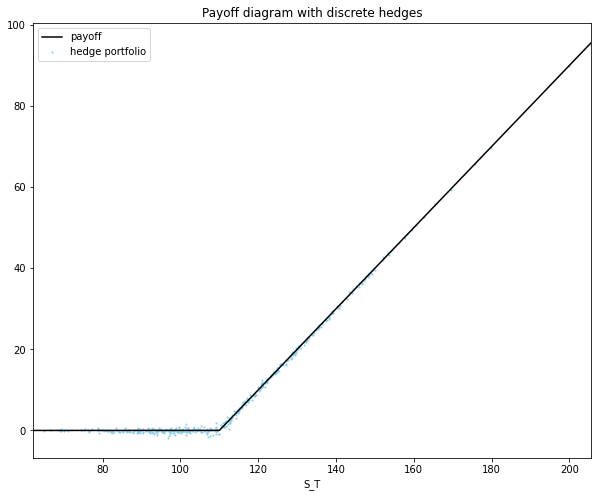

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
St, Π, C = hedge_engine(1)
neworder = St.argsort()
ax.plot(St[neworder], C[neworder], c="k", label="payoff")
ax.scatter(St, Π, s=1, c="skyblue", label="hedge portfolio")
ax.set_xlabel("S_T")
ax.legend()
ax.margins(x=0)
ax.set_title("Payoff diagram with discrete hedges");

In the above, the discrete re-balancing was done once every business day. How badly does this deteriorate if we decrease the hedge frequency - e.g. by switching to a monthly rebalancing scheme? The figure below gives some intuition: the hedge portfolios are markedly more off-target, but not comically so.   

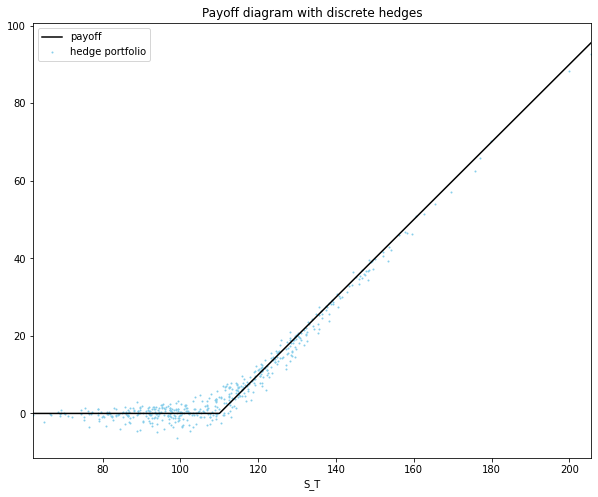

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
St, Π, C = hedge_engine(21)
neworder = St.argsort()
ax.plot(St[neworder], C[neworder], c="k", label="payoff")
ax.scatter(St, Π, s=1, c="skyblue", label="hedge portfolio")
ax.set_xlabel("S_T")
ax.legend()
ax.margins(x=0)
ax.set_title("Payoff diagram with discrete hedges");

To uncover the relationship between hedge frequencies and hedge errors, it is instructive to run this experiment for a range of hedge intervals, computing the standard deviation of the hedge error $(\Pi_T - C_T)$ in each case:

In [10]:
hd = [1, 3, 5, 7, 14, 21, 42, 63]
hp = []
he = []
for h in hd:
    hp.append(len(S.index[::h]))
    St, Π, C = hedge_engine(h)
    he.append(np.std(Π - C))

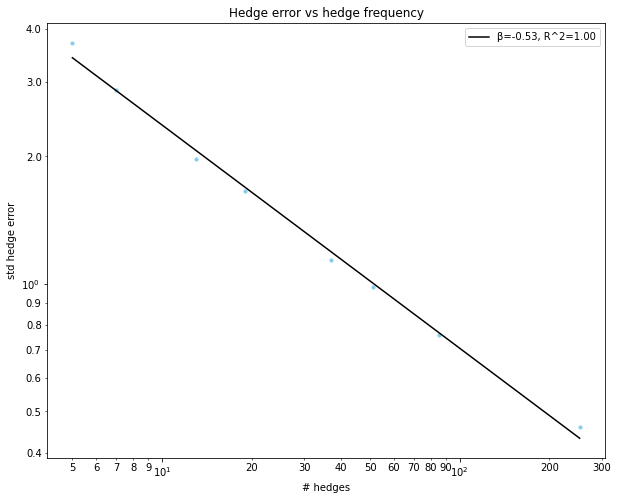

In [11]:
def plot_hedge_error(hp: list, he: list):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.scatter(hp, he, c="skyblue", s=10)
    hp2 = sm.add_constant(np.log(hp), prepend=True)
    res = sm.OLS(np.log(he), hp2).fit()
    he2 = np.exp(res.params[0]) * pow(np.array(hp), res.params[1])
    ax.plot(
        hp, he2, label="β={:.2f}, R^2={:.2f}".format(res.params[1], res.rsquared), c="k"
    )
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    ax.set_xlabel("# hedges")
    ax.set_ylabel("std hedge error")
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
    ax.set_title("Hedge error vs hedge frequency")


plot_hedge_error(hp, he)

The results are exhibited above. Based on this log-log plot we conclude that **the hedge error scales as one over the square root of the number of hedges performed during the lifetime of the option** ($R^2 \approx 1$). I.e. when you quadruple your hedge frequency you halve your hedge error.

Can we show this formally? Yes! It's slightly hairy, but the argument runs along the following lines: consider the hedge error $\epsilon_{\delta t}$ that arises between an option and a replicating portfolio $\Pi = B+\Delta S$ over some discrete interval $\delta t$:

$$
\begin{align}
\epsilon_{\delta t} & \equiv \delta C - \delta\Pi \\
&=\delta C - \delta (B + \Delta S) \\
&\approx \delta C - r B \delta t - \Delta \delta S \\
&= \delta C - r (C-\Delta S) \delta t - \Delta \delta S.
\end{align}
$$

Now $\delta S = \mu S \delta t + \sigma S \sqrt{\delta t} Z$, where $Z \sim N(0,1)$, and by Itô $\delta C \approx \theta \delta t + \Delta \delta S + \tfrac{1}{2} \Gamma (\delta S)^2$. Substituting these expression into the above, and ignoring terms $O(\delta t^2)$ we obtain

$$
\begin{align}
\epsilon_{\delta t} &\approx (\theta - rC + r \Delta S ) \delta t + \tfrac{1}{2} \Gamma \sigma^2 S^2 Z^2 \delta t \\
&= \tfrac{1}{2} \Gamma \sigma^2 S^2 (Z^2 - 1) \delta t,
\end{align}
$$

where the second line has made use of the Black-Scholes PDE: $rC = \theta + r\Delta S + \tfrac{1}{2} \sigma^2 S^2 \Gamma$. The cumulative hedge error from discrete hedging over the lifetime of the option is therefore

$$
\epsilon \approx  \sum_{i=1}^n \tfrac{1}{2} \Gamma_i \sigma^2 S_i^2 (Z_i^2 - 1) \delta t, 
$$

where $\Gamma_i$ is understood to be the gamma at time $t_i$ (ttm $T-t_i$) when spot is $S_i$. By iterated expectations this has expectation 0 (recall $\mathbb{E}[Z^2]=1$). Meanwhile the variance of the hedge error is approximately

$$
\mathbb{V}[\epsilon] \approx \mathbb{E} \left[  \sum_{i=1}^n \tfrac{1}{2} (\Gamma_i S_i^2)^2 (\sigma^2 \delta t)^2 \right]
$$

since $\mathbb{E}[(Z^2-1)^2] = \mathbb{E}[Z^2-2Z^2+1] = 3-2+1 = 2$. Evaluating this requires some effort. Derman and Miller provide (some) of the hard work (see eqns. (6.8) and (6.9)) if you are interested. Here, the upshot will do:

$$
\mathbb{V}[\epsilon] \approx  \sum_{i=1}^n \tfrac{1}{2} S_0^4 \Gamma_0^2 \sqrt{\frac{T^2}{T^2-t_i^2}} (\sigma^2 \delta t)^2 \approx \frac{\pi}{4} n (S_0^2 \Gamma_0 \sigma^2 \delta t)^2,
$$

where $n \equiv (T-t)/\delta t$. Finally, it is well known that gamma can be expressed as vega through $S_0^2 \Gamma_0 \sigma (T-t) = \nu$. Using this fact, we arrive at

$$
\mathbb{V}[\epsilon] \approx \frac{\pi}{4n} (\sigma \nu)^2 \Longrightarrow \text{std}(\epsilon) \approx \frac{\sigma}{\sqrt{n}} \nu
$$

which is the $\propto 1/\sqrt{n}$ relationship we wanted to show. 

# 2: Gamma Hedging at Discrete Intervals <a name="essay2"></a>

In the previous section we demonstrated that discrete time delta hedges introduce discrepancies between our replicating portfolio and the derivative price we are trying to mimic. Can these imperfections be mitigated somewhat through a more careful hedging scheme? Yes! By neutralising our portfolio not only to first order changes in the underlying, but also the second order ones, we obtain noticeably better results. 

These so-called **gamma hedges** are accomplished by introducing a dynamically updated position in a *second* non-linear derivative written on the same underlying security. For example, we can imagine replicating the call option $C_1 = C(K_1,T)$ by the portfolio $\Pi = B + \pi_S S + \pi_C C_2$ where $C_2 = C(K_2, T)$, $K_1 \neq K_2$ and the $\pi$s are adjustable weights. To see how this helps, consider a small change in $C_1$:

$$
\delta C_1 = \theta_1 \delta t + \Delta_1 \delta S + \tfrac{1}{2} \Gamma_1 \delta S^2
$$

vs. the corresponding change in the replicating portfolio:

$$
\delta\Pi = \delta B + \pi_S \delta S + \pi_C(\theta_2 \delta t + \Delta_2 \delta S + \tfrac{1}{2} \Gamma_2 \delta S^2).
$$

To hedge the $\delta S^2$ exposure of $C_1$, we must clearly set 

$$\pi_C = \frac{\Gamma_1 }{ \Gamma_2}. $$ 

Therefore, to hedge the $\delta S$ exposure, the "corrected" delta hedge is of the form 

$$\pi_S = \Delta_1 - \pi_C \Delta_2.$$

The relevance of this can be gauged from the following gamma adjusted hedge engine. Note that for our purposes, at each rebalancing point, the hedging derivative $C_2$ is chosen to be at-the-money: $K_2 = S$. This means that whatever derivative was used in the preceding hedge period must be fully liquidated (since spot has moved almost surely). Note that this is different to the approach taken by Poulsen (2007) wherein the strike of the hedge option is kept fixed. While this superficially seems simpler and more cost-effective, the problem with this approach is that gamma for non-at-the-money near-expiry options is damn well zero. This can lead to truly explosive behaviour in an un-capped $\pi_C$, and astronomical hedge errors, which is less than desirable.   

In [12]:
def hedge_engine_gamma(h_period: int) -> tuple:
    """
    Replicating portfolio for C with gamma correction, rebalanced at discrete time intervals
    """
    
    for t in S.index[::h_period]:
        dt = S.index[::h_period][1]
        if t == 0:
            St = S.loc[0].values
            V_1 = BSM(St, K, τ, σ, r, 0, o)
            V_2 = BSM(St, St, τ, σ, r, 0, o)
            C_1, Δ_1, Γ_1 = V_1.pdg()
            C_2, Δ_2, Γ_2 = V_2.pdg()
            π_C = Γ_1 / Γ_2
            π_S = Δ_1 - π_C * Δ_2
            B = C_1 - π_S * St - π_C * C_2
        else:
            St_old = St
            St = S.loc[t].values
            V_22 = BSM(St, St_old, τ - t, σ, r, 0, o)
            Π = B * np.exp(r * dt) + π_S * St + π_C * V_22.price()

            V_1 = BSM(St, K, τ - t, σ, r, 0, o)
            V_2 = BSM(St, St, τ - t, σ, r, 0, o)
            C_1, Δ_1, Γ_1 = V_1.pdg()
            C_2, Δ_2, Γ_2 = V_2.pdg()
            π_C = Γ_1 / Γ_2
            π_S = Δ_1 - π_C * Δ_2
            B = Π - π_S * St - π_C * C_2

    if t < τ:
        St_old = St
        St = S.iloc[-1].values
        V_22 = BSM(St, St_old, 0, σ, r, 0, o)
        Π = B * np.exp(r * (τ - t)) + π_S * St + π_C * V_22.price()
        C_1 = BSM(St, K, 0, σ, r, 0, o).price()

    return St, Π, C_1

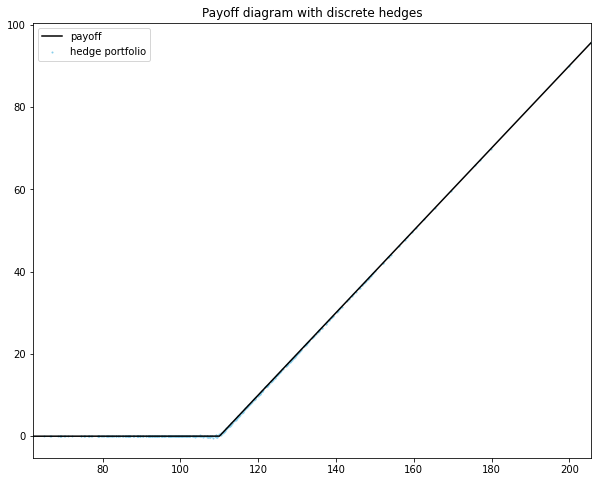

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
St, Π, C = hedge_engine_gamma(1)
neworder = St.argsort()
ax.plot(St[neworder], C[neworder], c="k", label="payoff")
ax.scatter(St, Π, s=1, c="skyblue", label="hedge portfolio")
ax.legend()
ax.margins(x=0)
ax.set_title("Payoff diagram with discrete hedges");

Discrete time delta-gamma hedging once every business day is visually superior to the analogous delta hedge.

What is the performance across various hedge frequencies?

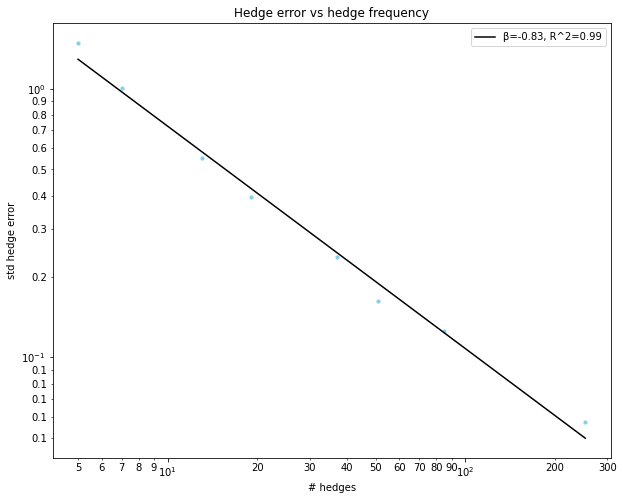

In [14]:
hd = [1, 3, 5, 7, 14, 21, 42, 63]
hp = []
he = []
for h in hd:
    hp.append(len(S.index[::h]))
    St, Π, C = hedge_engine_gamma(h)
    he.append(np.std(Π - C))

plot_hedge_error(hp, he)

By inspection **delta-gamma hedging looks about three to four times better than the corresponding delta hedge**. Also note that the hedge error decays somewhat faster than before.

While this seems like an open invitation to always hedge the gamma, one cannot ignore that the real world comes with transaction costs. Bid-ask spreads in the derivatives landscape are invariably worse off than for the underlying security. Trading too frequently in options, crossing the spread every time, will nuke your PnL.    

# 3: Hedging with Volatility Uncertainty <a name="essay3"></a>

Empirically, the volatility implied by the options market rarely coincides perfectly with the volatility realised by the underlying security - a phenomenon which extends beyond pure estimation error. It transpires that the market "conspires" to price in an implied volatility, which *on average* exceeds realised volatility, often by several percentage points. The reason for this discrepancy is attributable to the market's desire for insurance against large draw-downs (model risk) and its readiness to pay a premium for it. Specifically, investors are *net buyers* of options as they offer a comparatively cost-effective way of hedging one's exposure to the underlying security (it is an interesting fact that U.S. equity options exhibited no 'vol smile' prior to the stock crash of '87).

Regardless of the governing cause, one is left wondering what the impact of this is on hedging. Should our delta be based on the implied volatility, $\sigma_i$, the realised volatility, $\sigma_r$, or something else altogether? In the hedge engine below, I consider the rebalancing of a self-financing portfolio which is short one call option (sold at market value, $\sigma_i$), and long delta units of the underlying security, where the delta is specified according to some arbitrary hedge volatility $\sigma_h$.

In [15]:
def hedge_engine_vol(h_period: int, σ_i: float, σ_h: float, **kwargs) -> tuple:
    """
    PnL of self-financing portfolio Π = - C + B + ΔS when S diffuses with σ,
    C is traded at σ_i, and Δ is using σ_h.
    """
    
    if kwargs.get("new_paths", False):
        X = path_simulator(M=kwargs.get("M", 1000), dt=kwargs.get("dt", 1 / 252))
    else:
        X = S.copy()

    dt = X.index[::h_period][1]

    Π = pd.DataFrame(0, index=X.index[::h_period], columns=X.columns)
    for t in X.index[::h_period]:
        if t == 0:
            St = X.loc[0].values
            C_i = BSM(St, K, τ, σ_i, r, 0, o).price()
            Δ_h = BSM(St, K, τ, σ_h, r, 0, o).delta()
            B = C_i - Δ_h * St
        else:
            St = X.loc[t].values
            C_i = BSM(St, K, τ - t, σ_i, r, 0, o).price()
            Π.loc[t] = -C_i + B * np.exp(r * dt) + Δ_h * St
            Δ_h = BSM(St, K, τ - t, σ_h, r, 0, o).delta()
            B = Π.loc[t] + C_i - Δ_h * St

    if t < τ:
        St = X.iloc[-1].values
        C_i = BSM(St, K, 0, σ_i, r, 0, o).price()
        final = -C_i + B * np.exp(r * (τ - t)) + Δ_h * St
        extra = pd.DataFrame(final, index=[τ], columns=S.columns)
        Π = pd.concat([Π, extra])

    return Π

Consider a world with the following parameter specifications:

In [16]:
σ_r = σ  # = 0.2
σ_i = 0.3

Hedging with the *realised volatility* for our $M$ simulated paths we obtain the PnL exhibited below: stochastic paths which make money over time, roughly converging within the same ballpark at expiry.  

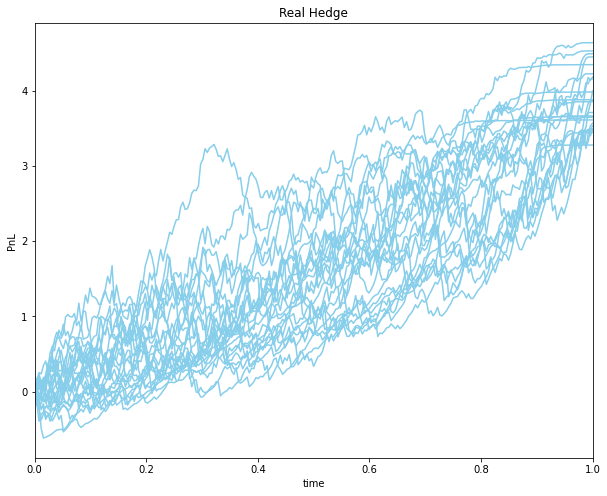

In [17]:
Π = hedge_engine_vol(1, σ_i, σ_r)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(Π[Π.columns[::20]], c="skyblue")
ax.set_title("Real Hedge")
ax.set_xlabel("time")
ax.set_ylabel("PnL")
ax.margins(x=0);

Meanwhile, if we hedge with the *implied volatility* the pattern changes dramatically: the PnL paths are now visually a lot smoother, but appear to distribute themselves over a much wider range at expiry. 

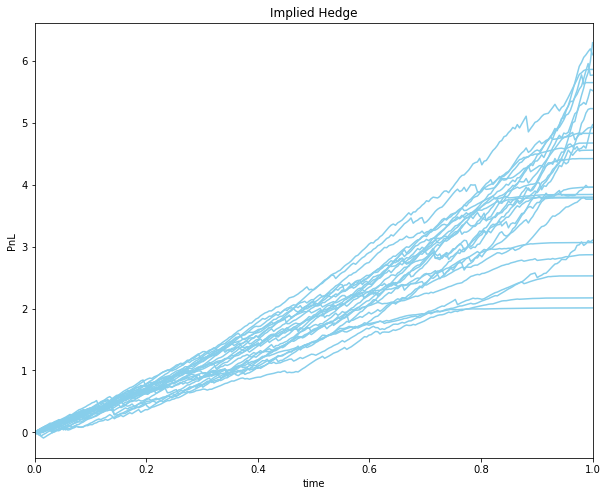

In [18]:
Π = hedge_engine_vol(1, σ_i, σ_i)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(Π[Π.columns[::20]], c="skyblue")
ax.set_title("Implied Hedge")
ax.set_xlabel("time")
ax.set_ylabel("PnL")
ax.margins(x=0);

How do we account for this? Well, we can formally derive these results in a few easy steps. The portfolio we are holding is of the form $\Pi = -C_i + B + \Delta_h S$, where $C_i = C(\sigma_i, K, \tau)$ is the option sold at market value, $\Delta_h=\Delta(\sigma_h)$ is the hedge ratio we deem appropriate, and $S$ is the underlying security with real dynamics $dS=\mu S dt + \sigma_r S dW$. By the self-financing condition, the infinitesimal change in the portfolio is:

$$
\begin{align}
d\Pi &= -dC_i + rBdt + \Delta_h dS \\
&= -dC_i + r(C_i - \Delta_h S)dt + \Delta_h dS \\
&= -dC_i + rC_idt + \Delta_h (dS - rSdt)
\end{align}
$$

Meanwhile, applying Itô's lemma to $C_h$ we have

$$
\begin{align}
dC_h &= \theta_h dt + \Delta_h dS + \tfrac{1}{2} \Gamma_h dS^2 \\
&= \theta_h dt + \Delta_h dS + \tfrac{1}{2} \Gamma_h \sigma_r^2 S^2 dt \\
&= (rC_h - r \Delta_h S - \tfrac{1}{2} \Gamma_h \sigma_h^2 S^2) dt + \Delta_h dS + \tfrac{1}{2} \Gamma_h \sigma_r S^2 dt \\
& = rC_h dt + \Delta_h (dS - rSdt) - \tfrac{1}{2} (\sigma_h^2 - \sigma_r^2) \Gamma_h S^2 dt,  
\end{align}
$$

where the second equality uses the definition of $dS$, and the third equality the Black-Scholes formula. Subtracting $dC_h$ from $d\Pi$ we get

$$
\begin{align}
d\Pi &= -dC_i +dC_h + r(C_i - C_h)dt + \tfrac{1}{2} (\sigma_h^2 - \sigma_r^2) \Gamma_h S^2 dt \\
&= e^{rt}d(e^{-rt}(C_h - C_i)) + \tfrac{1}{2} (\sigma_h^2 - \sigma_r^2) \Gamma_h S^2 dt. \\
\end{align}
$$

Thus, defining the *discounted* PnL $d\tilde{\Pi} \equiv e^{-rt} d\Pi$, it follows that the total present-valued gain from holding the hedge portfolio is

$$
\tilde{\Pi}_0^T = C_{0,i} - C_{0,h} + \tfrac{1}{2} \int_0^T e^{-rt}(\sigma_h^2 - \sigma_r^2) \Gamma_h S^2 dt, 
$$

since $C_{T,i} = C_{T,h} = (S_T - K)^+$. This significant result is sometimes known as **the fundamental theorem of derivatives trading**. At its core it highlights that delta hedged options effectively are bets on variance. 

We are also now in a position to formalise our simulation findings above. Upon hedging with the realised volatility we observe that the terminal PnL is 

$$
\tilde{\Pi}_0^T(\sigma_h = \sigma_r) = C_{0,i} - C_{0,r},$$

which is a deterministic quantity. However, $d\Pi$ blatantly depends on the $dC$s and thence the Brownian increment $dW$. In other words: **hedging with the realised volatility leads to the same eventual PnL, but the path there will be rugged O(dW) and probabilistic**. We can crank up the hedge frequency in our simulation experiment to see this more vividly. In the plot below we have resorted to intra-day hedging to cement the point on terminal convergence. Following Derman and Miller (eqn. 5.41) we've also plotted the continuous time upper and lower boundaries on the PnL.

In [19]:
Π = hedge_engine_vol(1, σ_i, σ_r, **{"new_paths": True, "M": 30, "dt": 1 / 5000})

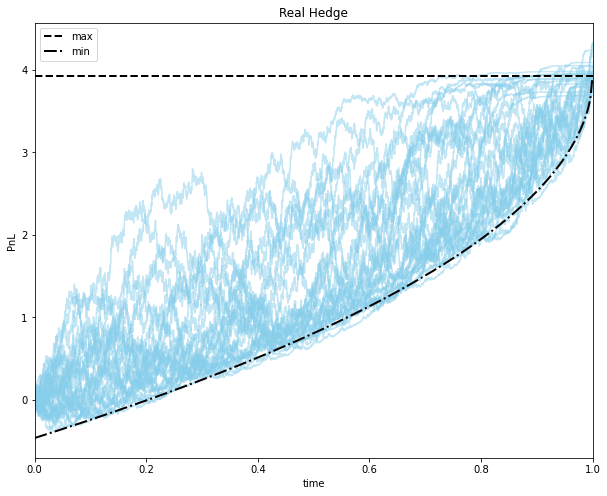

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(Π, alpha=0.5, c="skyblue", zorder=1)
ax.set_title("Real Hedge")
ax.set_xlabel("time")
ax.set_ylabel("PnL")
maxpnl = np.exp(r * τ) * (
    BSM(S_0, K, τ, σ_i, r, 0, o).price() - BSM(S_0, K, τ, σ_r, r, 0, o).price()
)
ax.hlines(
    maxpnl,
    xmin=0,
    xmax=τ,
    color="k",
    label="max",
    linewidth=2,
    linestyle="dashed",
    zorder=2,
)
t_min = np.array(S.index)
mt1 = np.exp(r * τ) * (
    BSM(S_0, K, τ, σ_i, r, 0, o).price() - BSM(S_0, K, τ, σ_r, r, 0, o).price()
)
minpnl = mt1 + 2 * K * np.exp(r * t_min) * (
    norm.cdf(0.5 * (σ_r - σ_i) * np.sqrt(τ - t_min)) - 0.5
)
ax.plot(t_min, minpnl, c="k", label="min", linewidth=2, linestyle="-.", zorder=3)
ax.legend()
ax.margins(x=0);

As for hedging with the implied volatility, we find that the terminal PnL is the stochastic quantity

$$
\tilde{\Pi}_0^T(\sigma_h = \sigma_i) =  \tfrac{1}{2} \int_0^T e^{-rt}(\sigma_i^2 - \sigma_r^2) \Gamma_h S^2 dt, 
$$

but on an incremental basis $d\Pi = \tfrac{1}{2} (\sigma_i^2 - \sigma_r^2) \Gamma_h S^2 dt$. **Implied volatility hedges thus spawn a probabilistic terminal payoff, but the path taking you there will be smooth, O(dt)**.

While the assumptions made in this section are of an idealised nature, it is noteworthy that the point about path ruggedness has some empirical support: this is seen in Ellersgaard et al. (2017) where delta-hedged S&P500 index options are considered. 

# 4: Hedging with Transaction Costs <a name="essay4"></a>

So far we have indulged Black and Scholes in their assumption of a frictionless economy. Nonetheless, one inevitably does wonder what impact transaction costs have on the pricing *and* hedging of financial derivatives. For simplicity we'll assume that investors pay transaction costs in the underlying security in proportion to the total value transacted (number of units * share price) i.e. $tc = \lambda |N| S$. Prima facie, if we were to pay this in a continuous time delta hedge, our costs would be infinite! Something is indeed rotten in the state of Denmark.

While an obvious solution is to keep hedge rebalancings to discrete intervals, possibly only adjusting the delta if the discrepancy is "sufficiently large", this clearly is neither rigorous nor in any sense optimal.

Hodges and Neuberger (1989) were amongst the first to take this problem seriously. In a nutshell, their proposed solution is an example of utility indifference pricing, wherein assets are priced at the level $p$ that make investors indifferent between (i) doing nothing and not having the asset in their portfolio, and (ii) paying/receiving $p$ and going long/shorting that asset in their portfolio. More explicitly, they invite us to consider a representative investor with negative exponential utility preferences $U(W) = -e^{-\gamma W}$, where $\gamma$ codifies her level of risk aversion. The investor seeks to maximise her utility of terminal wealth. On the one hand, she can keep her money spread solely across a bank account and a stock in the portfolio $B + \Delta S$, and on the other she can consider *also* shorting the call option $C$. Defining the optimal value function   

$$
J_{\phi}(t, S_t, B_t, \Delta_t) = \max \mathbb{E}_t \left[ U(B_T + \Delta_T S_T - \phi (S_T-K)^+ \right],
$$

where $\phi \in \{0,1\}$, and the maximum runs over all feasible transaction strategies, utility indifference pricing asserts that the option price $C_t$ at time $t$ satisfies

$$
J_{1}(t, S_t, B_t+C_t, \Delta_t) = J_{0}(t, S_t, B_t, \Delta_t).
$$

**Solving this problem not only provides a unique price for the call option in a transaction cost environment, it also provides the optimal hedging strategy**. 

Alas, this optimal control problem has no analytic solution, and solving the Bellman equation numerically is computationally cumbersome. In practice, approximate (asymptotic) solutions are often used. E.g. Whalley and Wilmott (1994) showed that for small transaction costs, there is a band surrounding the theoretical Black-Scholes delta, wherein the investor should *not* rebalance her portfolio. Only if she is sufficiently over/under hedged should action be taken. The boundaries of this no-transaction region are given by $[\Delta_{BS} - L, \Delta_{BS} + L]$ where

$$
L = \left( \frac{3}{2} \frac{e^{-r\tau} \lambda S \Gamma^2}{\gamma} \right)^{\frac{1}{3}}.
$$

This has a number of pleasing properties: e.g. the band decreases when transaction costs go down, or the investor's risk aversion shoots up. However, it also suffers from some less desirable properties: e.g. numerical solutions to the Bellman equation do *not* center the band around the Black Scholes delta - nor do they produce symmetric results for long vs. short gamma positions. But it's a start! For a more accurate asymptotic boundary have a look at the work by Zakamouline (2006).

In the code below I have implemented the hedge bands of Whalley-Wilmott and Zakamouline.

In [21]:
class DeltaBand(BSM):
    def __init__(
        self,
        S: Union[float, np.array],
        K: Union[float, np.array],
        τ: Union[float, np.array],
        σ: Union[float, np.array],
        r: Union[float, np.array],
        q: Union[float, np.array],
        o: str,
        γ: Union[float, np.array] = 0.1,
        λ: Union[float, np.array] = 0.01,
    ):
        """
        This class implements solutions to the hedging with transaction costs problem.
        γ: risk aversion for exponential utility
        λ: proportional transaction cost of the underlying (S) (tc=λNS for N units of S)
        """

        super().__init__(S, K, τ, σ, r, q, o)
        self.γ = np.asarray(γ)
        self.λ = np.asarray(λ)
        assert (self.γ >= 0).all()
        assert (self.λ >= 0).all()

    def band(self, strat: str = "ww"):
        if strat == "ww":
            return self.whalley_wilmott()
        elif strat == "z":
            return self.zakamouline()
        elif strat == "nb":
            return self.no_band()
        else:
            raise NotImplementedError("The chosen strat does not exist")

    def no_band(self):
        """
        Let the band be H=0
        """
        return self.delta(), 0

    def whalley_wilmott(self) -> tuple:
        """
        Whalley Wilmott (1993,1994) asymptotic hedge band
        """

        Δ = self.delta()
        Γ = self.gamma()
        H = (1.5 * self.Dr * self.λ * self.S * Γ**2 / self.γ) ** (1 / 3)
        return Δ, H

    def zakamouline(self) -> tuple:
        """
        Zakamouline (2006) asymptotic hedge band, with modified delta
        """

        Γ = self.gamma()
        Q = (
            4.76
            * (self.λ**0.78 / τ**0.02)
            * ((self.Dr / self.σ) ** 0.25)
            * (self.γ * (self.S**2) * abs(Γ)) ** 0.15
        )
        σ_m = self.σ * np.sqrt(1 + Q)
        Φ1_m = norm.cdf(
            (np.log(self.S / self.K) + (self.r - self.q + 0.5 * σ_m**2) * self.τ)
            / (σ_m * np.sqrt(self.τ))
        )
        if self.o == "c":
            Δ_m = self.Dq * Φ1_m
        else:
            Δ_m = -self.Dq * (1 - Φ1_m)

        H_0 = self.λ / (self.γ * self.S * (self.σ**2) * self.τ)
        H_1 = (
            1.12
            * self.λ**0.31
            * self.τ**0.05
            * ((self.Dr / self.σ) ** 0.25)
            * (abs(Γ) / self.γ) ** 0.5
        )
        H = H_0 + H_1

        return Δ_m, H

An illustrative example of the no-transaction region is shown below:

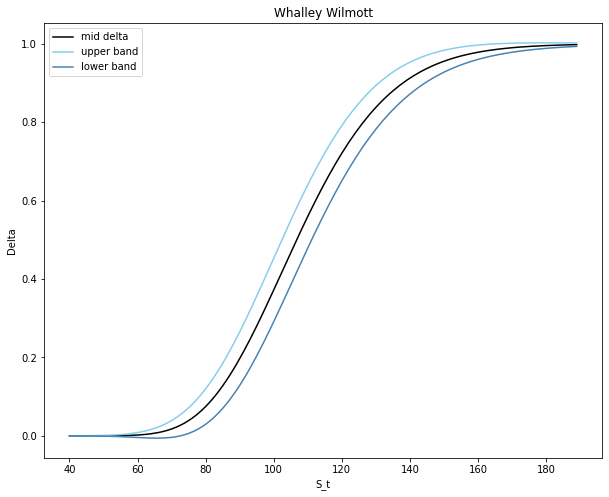

In [22]:
x = np.arange(K - 70, K + 80, 1)
a, b = DeltaBand(x, K, τ, σ, r, 0, "c", γ=1, λ=0.01).band("ww")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, a, "k", label="mid delta")
ax.plot(x, a + b, "skyblue", label="upper band")
ax.plot(x, a - b, "steelblue", label="lower band")
ax.set_title("Whalley Wilmott")
ax.set_xlabel("S_t")
ax.set_ylabel("Delta")
ax.legend();

In the hedge engine below I consider discrete time delta hedging with a band. The portfolio $\Pi = B + \Delta S - C$ is rebalanced in a self-financing manner over the lifetime of the option. The position on the underlying security is adjusted (here: back to mid) whenever it pierces either side of the no-transaction band. I assume proportional transaction costs throughout, but do not bother with the cost of unwinding at maturity. 

In [23]:
def hedge_engine_band(
    h_period: int, γ: float = 0.1, λ: float = 0.01, strat: str = "ww", **kwargs
) -> tuple:
    """
    Hedging the portfolio Π = - C + B + ΔS inside of a utility-optimal band a la Whalley Wilmott.
    γ is the investor's risk aversion, λ is the proportionality constant for transaction costs,
    strat is the band being considered
    """
    
    if kwargs.get("new_paths", False):
        X = path_simulator(M=kwargs.get("M", 500), dt=kwargs.get("dt", 1 / 252))
    elif kwargs.get("custom_paths", False):
        X = kwargs.get("df")
    else:
        X = S.copy()

    dt = X.index[::h_period][1]

    df_π = pd.DataFrame(
        0, index=S.index[::h_period], columns=X.columns
    )  # net portfolio value
    df_Δ = pd.DataFrame(
        0, index=S.index[::h_period], columns=X.columns
    )  # optimalrekin delta
    df_δ = pd.DataFrame(0, index=S.index[::h_period], columns=X.columns)  # hedge delta

    if X.index[::h_period][-1] < τ:
        extra = pd.DataFrame(1, index=[τ], columns=X.columns)
        df_π = pd.concat([df_π, extra])

    for m in tqdm(X.columns):
        for t in X.index[::h_period]:
            if t == 0:
                St = X.at[0, m]
                C, Δ = BSM(St, K, τ, σ, r, 0, o).pd()
                df_δ.at[0, m] = Δ
                df_Δ.at[0, m] = Δ
                B = C - Δ * (1 + λ) * St
            else:
                St = X.at[t, m]
                C = BSM(St, K, τ - t, σ, r, 0, o).price()
                Π = -C + B * np.exp(r * dt) + Δ * St

                Δ_m, H = DeltaBand(St, K, τ - t, σ, r, 0, o, γ, λ).band(strat)
                if (Δ < Δ_m - H) and (t < τ):
                    Δ_old = Δ
                    Δ = Δ_m  # -H
                    tc = λ * abs(Δ - Δ_old) * St
                elif (Δ > Δ_m + H) and (t < τ):
                    Δ_old = Δ
                    Δ = Δ_m  # +H
                    tc = λ * abs(Δ - Δ_old) * St
                else:
                    tc = 0

                Π_tc = Π - tc  # portfolio net of transaction costs
                B = Π_tc + C - Δ * St  # new bank account value

                df_π.at[t, m] = Π_tc
                df_Δ.at[t, m] = Δ_m
                df_δ.at[t, m] = Δ

        if t < τ:
            St = X.at[τ, m]
            C = BSM(St, K, 0, σ, r, 0, o).price()
            df_π.at[τ, m] = -C + B * np.exp(r * (τ - t)) + Δ * St

    return df_π, df_Δ, df_δ

Again, for illustrative purposes I exhibit some of the individual portfolio PnL paths below, side-by-side with the running deltas (mid delta and what is actually held). As you can see, violent moves in the mid delta causes us to adjust our position. For substantial periods of time we find ourselves not adjusting our portfolio at all (for the chosen parameter specifications).

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.93it/s]


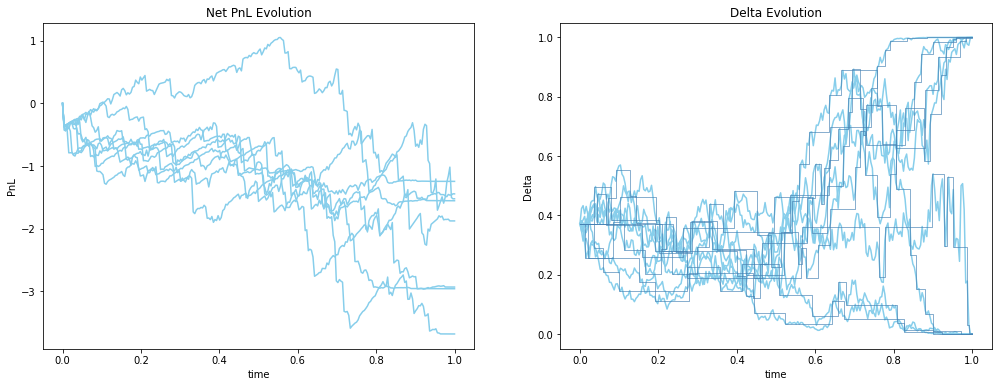

In [24]:
w, Δ, δ = hedge_engine_band(
    1, γ=1, strat="ww", **{"new_paths": True, "M": 8, "dt": 1 / 252}
)
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
ax[0].plot(w, c="skyblue")
ax[0].set_title("Net PnL Evolution")
ax[0].set_xlabel("time")
ax[0].set_ylabel("PnL")

ax[1].plot(Δ, label="mid delta", c="skyblue")
ax[1].step(
    δ.index, δ.values, label="trade delta", c="steelblue", linewidth=0.8, alpha=0.8
)
ax[1].set_title("Delta Evolution")
ax[1].set_xlabel("time")
ax[1].set_ylabel("Delta");

Below I've plotted the histograms of the terminal PnL from hedging at every discrete interval together with the terminal PnL from hedging with the Whalley Wilmott band. Clearly, the latter is to be preferred.

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:01<00:00,  4.06it/s]


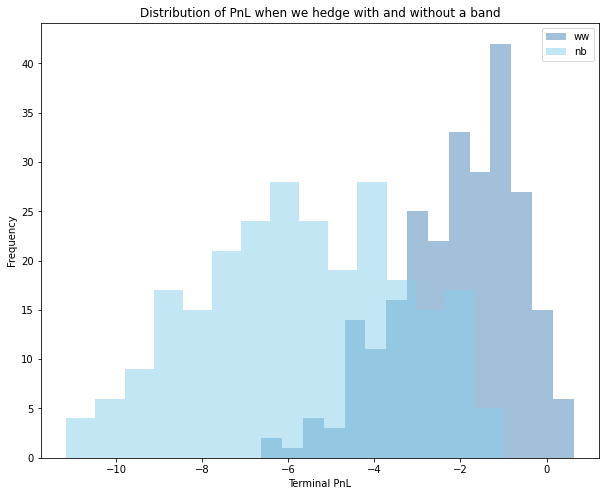

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
X = path_simulator(M=250, dt=1 / 252)
for st, c in zip(["ww", "nb"], ["steelblue", "skyblue"]):
    w, b1, c1 = hedge_engine_band(1, γ=1, strat=st, **{"custom_paths": True, "df": X})
    ax.hist(w.iloc[-1], alpha=0.5, label=st, bins=15, color=c)
ax.set_xlabel("Terminal PnL")
ax.legend()
ax.set_ylabel("Frequency")
ax.set_title("Distribution of PnL when we hedge with and without a band");

A popular objection to the hedge band idea is that it involves utility functions, which are inherently subjective. While this certainly is true, I have my doubts how forceful this argument actually is. For starters $\gamma$ can be viewed as a simple hyper-parameter: it us up to the investor to tune it to his or her liking. Secondly, Davis et al. showed that the results presented here are largely invariant across (credible) utility functions. Finally, utility functions, while largely absent from financial engineering, are ubiquitous in financial economics more broadly: portfolio optimisation problems are classical examples thereof (see Merton etc). Chances are that you have already tacitly used them. 

**Note**: In Ellersgaard and Tegner (2017) we consider a modification of this problem wherein the hedger targets life-time proximity to the Black-Scholes delta, when the underlying is traded in a limit order book.

# 5: Risk Minimising Hedges <a name="essay5"></a>

Not all risks can be perfectly hedged. At times the only realistically available hedge instrument will have an imperfect correlation with the risk we a trying to quell. What should be done in these scenarios? Well, an obvious idea is to opt for a position in the hedging asset which renders the variance of the overall portfolio return as small as possible. For example, imagine we a short a plain vanilla call option $C=C(K,\tau)$. Unlike anything considered thus far, the underlying security is governed by a number of stochastic drivers, for instance a stoch-vol dynamics a la Heston:

$$
\begin{align}
dS_t &= \mu S_t dt + \sqrt{V_t} S_t dW_1, \\
dV_t &= \kappa (\theta - V_t) dt + \zeta \sqrt{V_t} dW_2, \\
\end{align}
$$

where $V_t$ is the instantaneous variance, $\theta$ the long run variance level, $\kappa$ the speed of mean reversion, $\zeta$ is a "vol-of-vol" parameter, and the Wiener increments have correlation $\rho$. Clearly, we cannot neutralise the risks associated with a call option with a position on the underlying stock alone. A complete hedge would involve taking a position in a second derivative as well. Supposing this is not a viable option (pun intended). A risk minimising hedge would involve finding the position weight $w$ which minimises 

$$
\text{Var}[d\Pi] = \text{Var}[-dC + w dS].
$$

The answer is *not* the Black-Scholes delta nor the Heston equivalent. To see this note that by Itô:

$$
dC = O(dt) + \Delta \sqrt{V} S dW_1 + \nu \zeta \sqrt{V} dW_2,
$$

where $\Delta = \partial_S C$ and $\nu = \partial_V C$. Hence,

$$
\begin{align}
\min_w \text{Var}[d\Pi] &= \min_w \left \{ w^2 \text{Var}[dS] - 2w\text{Cov}[dC,dS] \right \} \\
&= \min_w \left \{ w^2 V S^2 dt - 2w\text{Cov}[dC,dS] \right \} \\
&= \min_w \left \{ w^2 V S^2 dt - 2w [\Delta V S^2 + \rho \nu \zeta V S]dt \right \}. \\
\end{align}
$$

Differntiating $\text{Var}[d\Pi]$ with respect to $w$ and equating to zero, we find that 

$$
w_{\min} = \Delta + \rho \frac{\zeta \nu}{S},
$$

(the solution is a minimum since $V S^2>0$). **The risk minimising hedge ergo involves the (Heston) delta as well as a correctional term involving the variance sensitivity, vega**. Note that if the vol-of-vol is zero, or the Wiener increments are independent, the correction is zero since there is either nothing to additionally hedge, or no way of hedging it. Finally the vega correction is largest for near-at-the-money options, where the flux between being in and out of the money is the greatest. 

In case it is not sufficiently obvious: the risk minimising hedge strategy extends beyond stochastic volatility. However, it is one obvious application. To verify its practical utility, we will consider a simulation experiment comparing the performance of $w_\min$ vs $\Delta$. To this end we need a couple of helper functions.

First we need a Heston option pricer. In the code below I use the quasi-analytical pricing formula found in Crisóstomo (2014) alongside Greeks derived by myself.

In [26]:
class Heston:
    def __init__(
        self,
        S0: float,
        K: float,
        τ: float,
        V0: float,
        r: float,
        κ: float,
        θ: float,
        ζ: float,
        ρ: float,
        o: str,
    ):
        """
        Heston option pricer with delta and vega.
        Partly inspired by Crisóstomo, 2014 and
        https://github.com/sandershortway/BlackScholesHeston/blob/main/Heston.py

        S0: The spot price
        K: The strike price
        τ: The time to maturity
        V0: The spot variance
        r: The risk free rate
        κ: variance speed of mean reversion
        θ: long run variance
        ζ: The vol of variance
        ρ: The correlation
        o: The option type, call (c), put (p)

        Simon Ellersgaard Nielsen, 2023
        """

        assert S0 > 0
        assert K > 0
        assert τ >= 0
        assert V0 > 0
        assert θ > 0
        assert κ > 0
        assert ζ > 0
        assert r >= 0
        assert (ρ >= -1) and (ρ <= 1)
        assert o in ["c", "p"]

        self.S0 = S0
        self.K = K
        self.τ = τ
        self.V0 = V0
        self.θ = θ
        self.κ = κ
        self.ζ = ζ
        self.r = r
        self.ρ = ρ
        self.o = o

    def feller(self):
        return 2 * self.κ * self.θ >= self.ζ**2

    def price(self):
        if self.o == "c":
            if self.τ < 0.01:
                return max(self.S0 - self.K, 0)
            else:
                return self._call()
        else:
            if self.τ < 0.01:
                return max(self.K - self.S0, 0)
            else:
                return self._put()

    def _call(self):
        Ψ = lambda w: self._charfunc(False, w)

        i1 = lambda w: np.real(
            (np.exp(-1j * w * np.log(self.K)) * Ψ(w - 1j)) / (1j * w * Ψ(-1j))
        )
        I1 = quad(i1, 0, np.inf)
        Π1 = 0.5 + I1[0] / np.pi

        i2 = lambda w: np.real((np.exp(-1j * w * np.log(self.K)) * Ψ(w)) / (1j * w))
        I2 = quad(i2, 0, np.inf)
        Π2 = 0.5 + I2[0] / np.pi

        return self.S0 * Π1 - self.K * np.exp(-self.r * self.τ) * Π2

    def _put(self):
        call = self._call()
        return call + self.K * np.exp(-self.r * self.τ) - self.S0

    def _charfunc(self, ddv, w):
        α = -((w**2) / 2.0) - ((1j * w) / 2.0)
        β = self.κ - self.ρ * self.ζ * 1j * w
        γ = (self.ζ**2) / 2.0
        h = np.sqrt(β**2 - 4 * α * γ)
        rplus = (β + h) / (self.ζ**2)
        rmin = (β - h) / (self.ζ**2)
        g = rmin / rplus
        C = self.κ * (
            rmin * self.τ
            - (2 / self.ζ**2) * np.log((1 - g * np.exp(-h * self.τ)) / (1 - g))
        )
        D = rmin * ((1 - np.exp(-h * self.τ)) / (1 - g * np.exp(-h * self.τ)))
        if ddv:
            return D * np.exp(
                C * self.θ
                + D * self.V0
                + 1j * w * np.log(self.S0 * np.exp(self.r * self.τ))
            )
        else:
            return np.exp(
                C * self.θ
                + D * self.V0
                + 1j * w * np.log(self.S0 * np.exp(self.r * self.τ))
            )

    def delta(self):
        if self.τ < 0.01:
            if self.o == "c":
                return int(self.S0 >= self.K)
            else:
                return -int(self.S0 <= self.K)

        Ψ = lambda w: self._charfunc(False, w)
        i1 = lambda w: np.real(
            (np.exp(-1j * w * np.log(self.K)) * Ψ(w - 1j)) / (1j * w * Ψ(-1j))
        )
        I1 = quad(i1, 0, np.inf)
        Π1 = 0.5 + I1[0] / np.pi

        if self.o == "c":
            return Π1
        else:
            return Π1 - 1

    def delta_fd(self):
        ϵ = 0.0001
        S0 = self.S0
        self.S0 = S0 + ϵ
        p1 = self.price()
        self.S0 = S0 - ϵ
        p2 = self.price()
        self.S0 = S0

        return (p1 - p2) / (2 * ϵ)

    def vega(self):
        if self.τ < 0.01:
            return 0

        Ψ = lambda w: self._charfunc(False, w)
        dΨ = lambda w: self._charfunc(True, w)

        i1 = lambda w: np.real(
            (
                np.exp(-1j * w * np.log(self.K))
                * (Ψ(-1j) * dΨ(w - 1j) - dΨ(-1j) * Ψ(w - 1j))
            )
            / (1j * w * Ψ(-1j) ** 2)
        )
        I1 = quad(i1, 0, np.inf)
        Π1 = I1[0] / np.pi

        i2 = lambda w: np.real((np.exp(-1j * w * np.log(self.K)) * dΨ(w)) / (1j * w))
        I2 = quad(i2, 0, np.inf)
        Π2 = I2[0] / np.pi

        return self.S0 * Π1 - self.K * np.exp(-self.r * self.τ) * Π2

    def vega_fd(self):
        ϵ = 0.0001
        V0 = self.V0
        self.V0 = V0 + ϵ
        p1 = self.price()
        self.V0 = V0 - ϵ
        p2 = self.price()
        self.V0 = V0

        return (p1 - p2) / (2 * ϵ)

For this exercise, our parameters of choice will be:

In [27]:
S_0 = 110  # spot
K = 110  # strike
τ = 1  # time to maturity
μ = 0.1  # mean drift
V_0 = 0.25**2  # initial variance
r = 0.01  # risk free rate
o = "c"  # option type
κ = 10  # speed of mean reversion
θ = 0.3**2  # long run variance
ζ = 1.0  # vol of variance
ρ = -0.5  # correlation

We will assume there is no distinction between $\mathbb{P}$ and $\mathbb{Q}$ parameters.

To simulate Hestonian stock paths we can use the function below:

In [28]:
def heston_path_simulator(M: int = 100, dt: float = 1 / 252) -> pd.DataFrame:
    x = np.arange(0, τ + dt, dt)
    xb = x.reshape((len(x), 1))
    S = pd.DataFrame(0.0, index=x, columns=np.arange(0, M))
    V = pd.DataFrame(0.0, index=x, columns=np.arange(0, M))

    for ti, t in enumerate(xb):
        if ti == 0:
            S.iloc[0] = float(S_0)
            V.iloc[0] = float(V_0)
        else:
            Z1 = np.random.normal(0, 1, M)
            Z2 = np.random.normal(0, 1, M)
            dW1 = np.sqrt(dt) * Z1
            dW2 = np.sqrt(dt) * (ρ * Z1 + np.sqrt(1 - ρ**2) * Z2)

            S.iloc[ti] = S.iloc[ti - 1] + S.iloc[ti - 1] * (
                μ * dt + np.sqrt(V.iloc[ti - 1]) * dW1
            )
            V.iloc[ti] = np.maximum(
                V.iloc[ti - 1]
                + κ * (θ - V.iloc[ti - 1]) * dt
                + ζ * np.sqrt(V.iloc[ti - 1]) * dW2,
                0.01**2,
            )

    S = S.astype(float)
    V = V.astype(float)
    return S, V


S, V = heston_path_simulator(M=100)

As a sanity check, I have plotted the mean variance process over time, together with the half-life ($ln(2)/\kappa$) and the long run variance level $\theta$. 

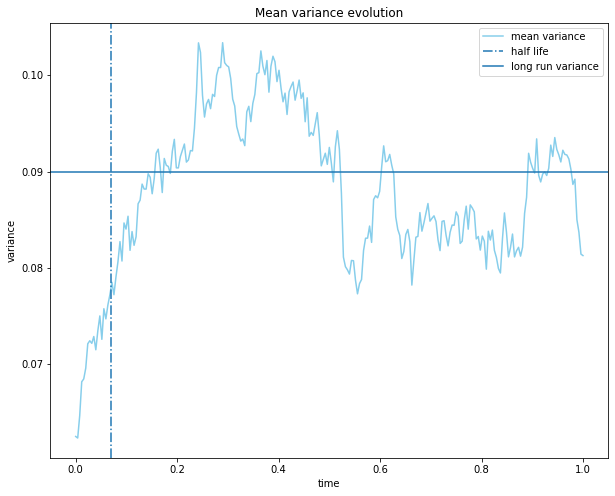

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
V.mean(axis=1).plot(ax=ax, label="mean variance", c="skyblue")
ax.axvline(np.log(2) / κ, label="half life", linestyle="-.")
ax.axhline(θ, label="long run variance")
ax.set_xlabel("time")
ax.set_ylabel("variance")
ax.legend()
ax.set_title("Mean variance evolution");

In the hedge engine below I consider a simple self financing strategy of the portfolio $\Pi = -C + B + wS$ where $w$ is taken to be both the Heston delta as well as the risk minimising hedge found above. We assume the market observes the variance process directly without any estimation uncertainty. 

**Note**: computing Heston prices and Greeks are a computationally costly affair, particularly when run in a Monte Carlo simulation. Avoid feeding the function too much data.  

In [30]:
def hedge_engine_riskmin(h_period: int, **kwargs) -> tuple:
    """
    Hedging the portfolio Π = - C + B + ΔS in a Heston stoch-vol economy when Δ is
    respectively taken to be dC/dS and the risk minimising hedge (with vega correction)
    """
    
    
    if kwargs.get("new_paths", False):
        X, Y = heston_path_simulator(
            M=kwargs.get("M", 100), dt=kwargs.get("dt", 1 / 252)
        )
    else:
        X = S.copy()
        Y = V.copy()

    dt = X.index[::h_period][1]

    Π_min = pd.DataFrame(0, index=X.index[::h_period], columns=X.columns)
    Π_ds = pd.DataFrame(0, index=X.index[::h_period], columns=X.columns)

    if X.index[::h_period][-1] < τ:
        extra = pd.DataFrame(1, index=[τ], columns=X.columns)
        Π_min = pd.concat([Π_min, extra])
        Π_ds = pd.concat([Π_min, extra.copy()])

    for m in tqdm(X.columns):
        for t in X.index[::h_period]:
            if t == 0:
                St = X.at[0, m]
                Vt = Y.at[0, m]
                option = Heston(St, K, τ, Vt, r, κ, θ, ζ, ρ, o)
                C = option.price()

                Δ_ds = option.delta()
                B_ds = C - Δ_ds * St

                ν = option.vega()
                Δ_min = Δ_ds + ρ * ζ * ν / St
                B_min = C - Δ_min * St
            else:
                St = X.at[t, m]
                Vt = Y.at[t, m]
                option = Heston(St, K, τ - t, Vt, r, κ, θ, ζ, ρ, o)
                C = option.price()

                pv_ds = -C + B_ds * np.exp(r * dt) + Δ_ds * St
                Δ_ds = option.delta()
                B_ds = pv_ds + C - Δ_ds * St
                Π_ds.at[t, m] = pv_ds

                pv_min = -C + B_min * np.exp(r * dt) + Δ_min * St
                ν = option.vega()
                Δ_min = Δ_ds + ρ * ζ * ν / St
                B_min = pv_min + C - Δ_min * St
                Π_min.at[t, m] = pv_min

        if t < τ:
            St = X.at[τ, m]
            Vt = Y.at[t, m]
            C = Heston(St, K, 0, Vt, r, κ, θ, ζ, ρ, o).price()
            Π_ds.at[τ, m] = -C + B_ds * np.exp(r * (τ - t)) + Δ_ds * St
            Π_min.at[τ, m] = -C + B_min * np.exp(r * (τ - t)) + Δ_min * St

    return Π_min, Π_ds

In [31]:
warnings.filterwarnings("ignore", message=".*The maximum number")
warnings.filterwarnings(
    "ignore", message=".*The integral is probably divergent"
)  # TO DO: identify rare convergence issue
Π_min, Π_ds = hedge_engine_riskmin(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [33:08<00:00, 19.89s/it]


To see if the risk minimising hedge has a measurable impact, we compute the mean of the standard deviation of daily returns across the $M$ paths for both hedge ratios. Performing Welch's t-test, we see that the average PnL volatility delivered by the delta hedge is statistically higher than that of the risk minimising hedge. In other words, we've succeeded in our endeavor.    

In [32]:
μ_min = Π_min.diff().std().mean()
se_min = Π_min.diff().std().std() / np.sqrt(Π_min.shape[1])
μ_ds = Π_ds.diff().std().mean()
se_ds = Π_ds.diff().std().std() / np.sqrt(Π_ds.shape[1])
(μ_ds - μ_min) / np.sqrt(se_min**2 + se_ds**2)

2.504309528451767

# Sources

Note: if you see anything amiss in this notebook, let me know. Errare humanum est, perseverare autem diabolicum.

[Crisóstomo (2014) An Analysis of the Heston Stochastic Volatility Model: Implementation and Calibration Using Matlab](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2527818)

[Davis et al. (1993) European Option Pricing with Transaction Costs](https://web.ma.utexas.edu/users/zariphop/pdfs/TZ-7.pdf)

[Derman and Miller (2016) The Volatility Smile](https://www.amazon.co.uk/Volatility-Smile-Wiley-Finance/dp/1118959167)

[Ellersgaard et al (2017) The Fundamental Theorem of Derivative Trading -
exposition, extensions and experiments](https://www.oxford-man.ox.ac.uk/wp-content/uploads/2020/04/The-Fundamental-Theorem-of-Derivatives-Trading-Exposition-Extensions-and-Experiments.pdf)

[Ellersgaard and Tegner (2017) Optimal Hedge Tracking Portfolios
in a Limit Order Book](https://www.oxford-man.ox.ac.uk/wp-content/uploads/2020/04/Optimal-Hedge-Tracking-Portfolios-in-a-Limit-Order-Book.pdf)

[Hodges and Neuberger (1989) Optimal Replication of Contingent Claims under Transaction Costs](https://warwick.ac.uk/fac/soc/wbs/subjects/finance/research/wpaperseries/1989/89-07.pdf)

[Poulsen (2007) Four Things You Might Not Know about the Black-Scholes Formula](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=991344)

[Poulsen et al (2009) Risk minimization in stochastic volatility models:
model risk and empirical performance](https://www.ssoar.info/ssoar/bitstream/handle/document/22155/ssoar-2009-06-poulsen_et_al-risk_minimization_in_stochastic_volatility.pdf?sequence=1&isAllowed=y&lnkname=ssoar-2009-06-poulsen_et_al-risk_minimization_in_stochastic_volatility.pdf)

[Sinclair (2013) Volatility Trading](https://www.amazon.co.uk/Volatility-Trading-Website-Wiley/dp/1118347137/ref=sr_1_3?crid=3C5NFDJ05HW3O&keywords=volatility+trading&qid=1702760777&sprefix=volatility+tradi%2Caps%2C92&sr=8-3)

[Whalley and Wilmott (1997) An Asymptotic Analysis of an
Optimal Hedging Model for Option Pricing with Transaction Costs](https://onlinelibrary.wiley.com/doi/abs/10.1111/1467-9965.00034)

[Zakamouline (2006) Optimal Hedging of Options with Transaction Costs](https://efmaefm.org/0efmameetings/efma%20annual%20meetings/2005-Milan/papers/284-zakamouline_paper.pdf)

